In this notebook, k-means, agglomerative and DBSCAN clustering algorithms are run to assign cluster labels to the ECGs.

# Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Imports

In [2]:
!pip install tslearn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np
import math
import random
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from tslearn.clustering import TimeSeriesKMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from collections import Counter

     |████████████████████████████████| 798kB 7.9MB/s 


/usr/local/lib/python3.7/dist-packages/tslearn/clustering/kmeans.py:17: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  "Scikit-learn <0.24 will be deprecated in a "


# Set up Dataset

### **Open dataset**

Download the [MIT-BIH ECG Heartbeat Categorization Dataset](https://www.kaggle.com/shayanfazeli/heartbeat) from Kaggle and replace `/content/gdrive/MyDrive/COM3025_Group_Project/datasets/heartbeat.zip` with the location of the archive file.

In [3]:
!mkdir /content/kaggle
# Copy the dataset from Google Drive
!cp /content/gdrive/MyDrive/COM3025_Group_Project/datasets/heartbeat.zip /content/kaggle
!unzip /content/kaggle/heartbeat.zip -d /content/kaggle

Archive:  /content/kaggle/heartbeat.zip
  inflating: /content/kaggle/mitbih_test.csv  
  inflating: /content/kaggle/mitbih_train.csv  
  inflating: /content/kaggle/ptbdb_abnormal.csv  
  inflating: /content/kaggle/ptbdb_normal.csv  


In [4]:
# Open as pandas dataframes
arr_df_train = pd.read_csv('/content/kaggle/mitbih_train.csv', header=None)
arr_df_test = pd.read_csv('/content/kaggle/mitbih_test.csv', header=None)

# Join the two so that all samples belong to a cluster
arr_df = pd.concat([arr_df_test, arr_df_train], axis=0, ignore_index=True)

# Name label column
arr_df = arr_df.rename(columns={187: "Label"})
arr_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,Label
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,0.030992,0.028926,0.035124,0.026860,0.039256,0.035124,0.043388,0.047521,0.053719,0.053719,0.070248,0.072314,0.084711,0.097107,0.121901,0.132231,0.169421,0.196281,0.214876,0.235537,0.254132,0.264463,0.285124,0.272727,0.266529,0.239669,0.214876,0.173554,0.157025,0.123967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,0.304029,0.336996,0.377289,0.391941,0.439560,0.446886,0.457875,0.479853,0.512821,0.534799,0.586081,0.586081,0.604396,0.633700,0.615385,0.582418,0.564103,0.520147,0.490842,0.490842,0.468864,0.454212,0.450549,0.465201,0.450549,0.432234,0.424908,0.410256,0.391941,0.369963,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,0.106195,0.141593,0.128319,0.150442,0.132743,0.150442,0.132743,0.150442,0.123894,0.163717,0.137168,0.141593,0.132743,0.150442,0.128319,0.146018,0.119469,0.123894,0.101770,0.092920,0.070796,0.079646,0.066372,0.070796,0.079646,0.092920,0.088496,0.084071,0.079646,0.088496,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,0.102083,0.122917,0.150000,0.168750,0.172917,0.170833,0.168750,0.164583,0.156250,0.152083,0.147917,0.147917,0.145833,0.145833,0.141667,0.141667,0.147917,0.158333,0.168750,0.179167,0.191667,0.206250,0.220833,0.239583,0.258333,0.275000,0.287500,0.308333,0.320833,0.331250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,0.080537,0.104027,0.093960,0.117450,0.097315,0.134228,0.124161,0.161074,0.171141,0.194631,0.204698,0.261745,0.275168,0.332215,0.345638,0.395973,0.406040,0.456376,0.446309,0.446309,0.399329,0.369128,0.308725,0.295302,0.265101,0.271812,0.258389,0.268456,0.261745,0.281879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109441,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,0.052632,0.140351,0.119298,0.091228,0.140351,0.161404,0.105263,0.143860,0.143860,0.129825,0.147368,0.157895,0.164912,0.168421,0.154386,0.175439,0.164912,0.154386,0.182456,0.192982,0.196491,0.207018,0.217544,0.217544,0.256140,0.284211,0.294737,0.301754,0.301754,0.322807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
109442,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,0.078333,0.183333,0.275000,0.315000,0.361667,0.430000,0.481667,0.526667,0.543333,0.563333,0.581667,0.588333,0.600000,0.603333,0.613333,0.

In [5]:
# Count number of samples of each label over the whole dataset
arr_df["Label"].value_counts()

0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: Label, dtype: int64

### **Get Samples**

Set `drop_samples` to remove some samples

* `max_label_samples` is the maximum number of samples to keep in the training and testing data from each label type

In [6]:
drop_samples = True
max_label_samples = 2500

# Find all unique labels
unique_labels = np.unique(arr_df.Label)

# Remove some samples
if drop_samples:
  # Randomly shuffle rows
  shuffled_train = arr_df.sample(frac=1, random_state=1) # Random state makes samples reproducible
  # Create train_data
  train_data = None
  for label in unique_labels:
    # Find all rows in the DataFrame with the label
    train_label_rows = shuffled_train.loc[shuffled_train['Label'] == label]
    # Get the first n rows and drop the rest
    train_label_rows = train_label_rows.head(n=max_label_samples)
    # Check if initialised
    if isinstance(train_data, pd.DataFrame):
      train_data = train_data.append(train_label_rows)
    else:
      # Else create new DataFrame
      train_data = train_label_rows
# Otherwise use all data
else:
  train_data = arr_df

# Shuffle again to mix order label
train_data = train_data.sample(frac=1, random_state=1)
train_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,Label
96025,0.917037,0.859259,0.290370,0.000000,0.268148,0.327407,0.318519,0.318519,0.320000,0.318519,0.318519,0.324444,0.330370,0.328889,0.328889,0.340741,0.346667,0.355556,0.360000,0.371852,0.379259,0.380741,0.391111,0.398519,0.410370,0.417778,0.410370,0.422222,0.435556,0.435556,0.440000,0.453333,0.442963,0.416296,0.392593,0.368889,0.357037,0.339259,0.324444,0.325926,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
44371,0.982143,0.834821,0.339286,0.089286,0.080357,0.098214,0.062500,0.049107,0.026786,0.049107,0.035714,0.044643,0.044643,0.066964,0.058036,0.066964,0.062500,0.066964,0.071429,0.084821,0.089286,0.098214,0.111607,0.133929,0.138393,0.160714,0.174107,0.200893,0.209821,0.236607,0.254464,0.263393,0.267857,0.285714,0.263393,0.250000,0.209821,0.174107,0.138393,0.133929,...,0.013393,0.022321,0.017857,0.044643,0.035714,0.049107,0.044643,0.053571,0.066964,0.084821,0.089286,0.120536,0.116071,0.133929,0.142857,0.178571,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21426,0.802862,0.732909,0.624801,0.519873,0.359300,0.219396,0.117647,0.047695,0.000000,0.009539,0.027027,0.111288,0.213037,0.282989,0.341812,0.413355,0.456280,0.526232,0.580286,0.621622,0.624801,0.642289,0.642289,0.675676,0.670906,0.678855,0.689984,0.694754,0.707472,0.728140,0.729730,0.753577,0.782194,0.799682,0.810811,0.842607,0.864865,0.882353,0.893482,0.906200,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
98466,1.000000,0.882716,0.675926,0.240741,0.117284,0.169753,0.175926,0.120370,0.216049,0.228395,0.166667,0.225309,0.290123,0.268519,0.305556,0.308642,0.348765,0.336420,0.348765,0.385802,0.358025,0.438272,0.472222,0.456790,0.478395,0.506173,0.570988,0.537037,0.382716,0.416667,0.361111,0.398148,0.401235,0.308642,0.342593,0.333333,0.320988,0.345679,0.320988,0.327161,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
29498,1.000000,0.809984,0.209340,0.067633,0.281804,0.344605,0.320451,0.315620,0.322061,0.318841,0.318841,0.325282,0.328502,0.318841,0.322061,0.325282,0.326892,0.323671,0.325282,0.333333,0.331723,0.326892,0.328502,0.338164,0.334944,0.330113,0.333333,0.341385,0.342995,0.339775,0.342995,0.351047,0.352657,0.352657,0.360709,0.370370,0.367150,0.367150,0.370370,0.371981,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94432,0.985632,0.735632,0.278736,0.071839,0.086207,0.083333,0.045977,0.020115,0.017241,0.017241,0.028736,0.022989,0.025862,0.031609,0.031609,0.017241,0.028736,0.022989,0.022989,0.043103,0.020115,0.020115,0.034483,0.022989,0.020115,0.017241,0.020

Count number of samples with each label

In [7]:
label_counts = pd.DataFrame(data=train_data['Label'].value_counts(ascending=True)).sort_index().rename(columns={"Label": "Sample Count"})
label_counts.transpose() # Flip row + column order

,0.0,1.0,2.0,3.0,4.0
Sample Count,2500,2500,2500,803,2500


### **Add Augmented Samples**

Create more samples of the rarer classes through up-sampling and adding Gaussian noise

In [8]:
def remove_zeros(series):
  # Remove zeros from end of a list
  for element in reversed(series):
    if not element:
      del series[-1]
  else:
      return series

In [9]:
def add_gaussian_noise(time_series, divisor=8):
  time_series_length = len(time_series)
  # Remove padding zeros from the end of the time-series
  time_series = np.array(remove_zeros(list(time_series)))
  # Create Gaussian noise
  noise = np.random.normal(0, 0.1, time_series.shape)/divisor
  # Add noise to time-series
  noisy_time_series = np.add(time_series, noise)
  # Normalize values between 0 - 1 and round to 6 decimal places
  normalized_time_series = np.array([np.round((x - min(noisy_time_series))/(max(noisy_time_series) - min(noisy_time_series)), 6) for x in noisy_time_series])
  # Adding padding back by putting zeros at the end
  normalized_time_series = np.pad(normalized_time_series, (0, time_series_length - len(normalized_time_series)), 'constant')
  return normalized_time_series

In [10]:
# Create new DataFrame of augmented samples with added noise
noisy_train_data = pd.DataFrame(columns=np.append(train_data.columns.values, "Augmentation"))

# Iterate through label counts
for label, count in zip(label_counts.index, label_counts.values):
  # Check if less samples with the label then desired
  if count < max_label_samples:
    # Find all samples with that label
    for time_series in train_data.loc[shuffled_train['Label'] == label].iloc[:,:187].values:
      # Add random noise to sample
      normalized_time_series = add_gaussian_noise(time_series, divisor=random.randint(6, 10))
      # Round between two and six decimal places as this changes sample quality
      normalized_time_series = np.around(normalized_time_series, decimals=random.randint(2, 6))
      # Add new sample to DataFrame
      new_row = np.append(normalized_time_series, label)
      new_row = np.append(new_row, "Gaussian")
      noisy_train_data.loc[len(noisy_train_data)] = new_row

In [11]:
# Give new samples unique indexes
noisy_train_data.index = [idx for idx in range(len(arr_df), len(arr_df) + len(noisy_train_data))]
# Convert the time-series columns to float
for col in noisy_train_data.columns[:-1]:
  noisy_train_data[col] = noisy_train_data[col].astype(float)

View an augmented sample

* Changing `sample_idx` will show different samples

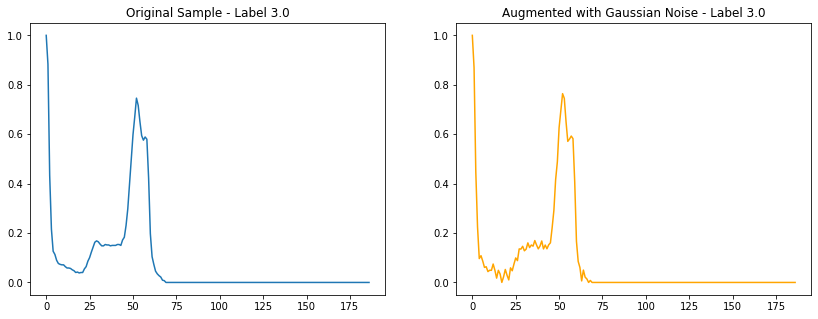

In [12]:
sample_idx = 0

if not noisy_train_data.empty:
  if sample_idx > len(noisy_train_data):
    sample_idx = len(noisy_train_data) - 1
  fig, axes = plt.subplots(1, 2, figsize=(14, 5))
  time_series = noisy_train_data.values[sample_idx]
  # Plot a sample from the training data
  label = time_series[len(time_series)-2:-1][0]
  axes[0].plot(train_data.loc[shuffled_train['Label'] == label].iloc[:,:187].values[sample_idx])
  # Plot the corresponding altered sample
  axes[1].plot(time_series[:-2], c="orange")
  axes[0].set_title("Original Sample - Label " + str(label))
  axes[1].set_title("Augmented with Gaussian Noise - Label " + str(label))
  plt.show()

Add new samples to the training data

In [13]:
# Add augmentation column to train_data and fill with NaN
augmented_train_data = train_data.copy()
augmented_train_data["Augmentation"] = np.nan
# Add augmented samples
augmented_train_data = pd.concat([augmented_train_data, noisy_train_data])
# Shuffle order
augmented_train_data = augmented_train_data.sample(frac=1, random_state=1)
augmented_train_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,Label,Augmentation
102666,0.905838,0.994350,1.000000,0.683616,0.325800,0.197740,0.139360,0.124294,0.094162,0.094162,0.075330,0.079096,0.071563,0.069680,0.064030,0.054614,0.039548,0.041431,0.030132,0.024482,0.013183,0.013183,0.005650,0.013183,0.015066,0.037665,0.041431,0.060264,0.077213,0.118644,0.139360,0.167608,0.167608,0.173258,0.165725,0.175141,0.163842,0.171375,0.163842,0.171375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,NaN
21407,1.000000,0.563574,0.573883,0.587629,0.580756,0.542955,0.560137,0.487972,0.378007,0.261168,0.089347,0.113402,0.144330,0.137457,0.178694,0.240550,0.240550,0.240550,0.250859,0.257732,0.264605,0.264605,0.264605,0.295533,0.271478,0.271478,0.281787,0.281787,0.285223,0.257732,0.261168,0.302406,0.323024,0.336770,0.353952,0.360825,0.367698,0.398625,0.398625,0.398625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,NaN
102441,1.000000,0.829404,0.531207,0.248266,0.110957,0.151179,0.145631,0.106796,0.099861,0.101248,0.097087,0.083218,0.080444,0.084605,0.088766,0.083218,0.099861,0.115118,0.124827,0.147018,0.163662,0.196949,0.231623,0.252427,0.281553,0.314840,0.346741,0.374480,0.389736,0.409154,0.413315,0.406380,0.402219,0.395284,0.373093,0.361997,0.341193,0.319001,0.292649,0.263523,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,NaN
96144,1.000000,0.824701,0.159363,0.000000,0.091633,0.163347,0.119522,0.151394,0.211155,0.191235,0.183267,0.223108,0.286853,0.334661,0.326693,0.302789,0.306773,0.306773,0.322709,0.322709,0.326693,0.342629,0.346614,0.334661,0.342629,0.374502,0.378486,0.378486,0.406375,0.422311,0.442231,0.450199,0.494024,0.537849,0.549801,0.537849,0.529880,0.549801,0.517928,0.478088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
20016,0.000000,0.047101,0.068841,0.090580,0.123188,0.152174,0.297101,0.365942,0.376812,0.405797,0.409420,0.427536,0.402174,0.416667,0.409420,0.431159,0.416667,0.434783,0.442029,0.471014,0.474638,0.518116,0.528986,0.557971,0.557971,0.568841,0.557971,0.536232,0.510870,0.492754,0.445652,0.423913,0.380435,0.365942,0.329710,0.326087,0.300725,0.311594,0.300725,0.322464,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102272,0.000000,0.047541,0.170492,0.247541,0.340984,0.388525,0.439344,0.459016,0.477049,0.542623,0.591803,0.627869,0.654098,0.677049,0.686885,0.701639,0.706557,0.727869,0.740984,0.763934,0.777049,0.786885,0.795082,0.808197,0.808197,0.819672,0.811475,0.804918,0.788525,0.775410,0.755738,0.734426,0.711475,0.693443,0.672131,0.655738,0.631148,0.618033,0.618033,0.609836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN
109598,1.000000,0.820000,0.430000,0.240000,0.130000,0.110000,0.110000,0.060000,0.070000,0.060000,0.090000,0.080000,0.090000,0.090000,0.090000,0.100000,0.070000,0.070000,0.080000,0.080000,0.100000,0.07000

Count number of samples with each label

In [14]:
augmented_label_counts = pd.DataFrame(data=augmented_train_data['Label'].value_counts(ascending=True)).sort_index().rename(columns={"Label": "Sample Count"})
augmented_label_counts.transpose()

,0.0,1.0,2.0,3.0,4.0
Sample Count,2500,2500,2500,1606,2500


### **Split into Test and Train**

Set `use_augmented = True` if using the training data with the new Gaussian noise samples

In [15]:
use_augmented = True

selected_train_data = augmented_train_data if use_augmented else train_data

X_train = selected_train_data.iloc[:,:187].values

print("Training sample shape: " + str(X_train.shape))

Training sample shape: (11606, 187)


# Clustering

### **Clustering Optimisation**

Set `run_optimisation = True` to find best clustering algorithm parameters

In [16]:
run_optimisation = False

#### K-Means and Agglomerative

Find best number of clusters for k-means and agglomerative based on silhouette coefficient
* Cells below still work if you stop this early
* Values can be viewed directly by running `kmeans_scores_df` or `agglomerative_scores_df` in a new cell

In [17]:
min_n = 10 # Can't be less than 2, can change these values
max_n = 20
step_n = 1

if run_optimisation:
  # Create dataframe to record silhouette coefficient
  kmeans_scores_df = pd.DataFrame(columns=["Cluster Number", "Silhouette Score", "Variance", "Standard Deviation"])
  agglomerative_scores_df = pd.DataFrame(columns=["Cluster Number", "Silhouette Score", "Variance", "Standard Deviation"])

  for n in range(min_n, max_n + 1, step_n):
    # Test k-means
    clustering_model = TimeSeriesKMeans(n_clusters=n, metric="euclidean", max_iter=3, random_state=0).fit(X_train)
    # Find number of samples in each cluster
    cluster_sizes_df = pd.DataFrame(list(Counter(clustering_model.labels_).items()), columns = ['Cluster', 'Number of Samples'])
    # Calculate variance and standard deviation
    variance = np.var(cluster_sizes_df['Number of Samples'].values)
    standard_deviation = np.std(cluster_sizes_df['Number of Samples'].values)
    # Record number of clusters, silhouette coefficient, variance and standard deviation
    kmeans_scores_df.loc[len(kmeans_scores_df)] = [n, silhouette_score(X_train, clustering_model.labels_), variance, standard_deviation]

    # Test agglomerative
    clustering_model = AgglomerativeClustering(n_clusters=n, affinity="euclidean").fit(X_train)
    cluster_sizes_df = pd.DataFrame(list(Counter(clustering_model.labels_).items()), columns = ['Cluster', 'Number of Samples'])
    variance = np.var(cluster_sizes_df['Number of Samples'].values)
    standard_deviation = np.std(cluster_sizes_df['Number of Samples'].values)
    agglomerative_scores_df.loc[len(agglomerative_scores_df)] = [n, silhouette_score(X_train, clustering_model.labels_), variance, standard_deviation]

In [18]:
if run_optimisation:
  try:
    # Set cluster number as index
    kmeans_scores_df = kmeans_scores_df.set_index("Cluster Number")
    agglomerative_scores_df = agglomerative_scores_df.set_index("Cluster Number")
  except:
    # Prevent errors if run twice
    None

  # Plot the graph
  fig, axes = plt.subplots(1, 3, figsize=(20, 4))
  # Can change x and y as the results you wish to investigate
  sns.lineplot(data=kmeans_scores_df, x="Cluster Number", y="Silhouette Score", label="K-Means", ax=axes[0])
  sns.lineplot(data=agglomerative_scores_df, x="Cluster Number", y="Silhouette Score", label="Agglomerative", ax=axes[0])
  sns.lineplot(data=kmeans_scores_df, x="Cluster Number", y="Variance", label="K-Means", ax=axes[1])
  sns.lineplot(data=agglomerative_scores_df, x="Cluster Number", y="Variance", label="Agglomerative", ax=axes[1])
  sns.lineplot(data=kmeans_scores_df, x="Cluster Number", y="Standard Deviation", label="K-Means", ax=axes[2])
  sns.lineplot(data=agglomerative_scores_df, x="Cluster Number", y="Standard Deviation", label="Agglomerative", ax=axes[2])
  plt.show()

Print best results
* If measure is `"Silhouette Score"` use `idxmax`
* If you change `measure` to `"Variance"` or `"Standard Deviation"`, make sure to use `idxmin`

In [19]:
if run_optimisation:
  measure = "Silhouette Score"
  if measure == "Silhouette Score":
    # Find highest scores
    best_n_clusters_kmeans = kmeans_scores_df[measure].idxmax()
    best_n_clusters_agglomerative = agglomerative_scores_df[measure].idxmax()
  else:
    # Find lowest values
    best_n_clusters_kmeans = kmeans_scores_df[measure].idxmin()
    best_n_clusters_agglomerative = agglomerative_scores_df[measure].idxmin()
  print("Cluster number with best " + measure + " for K-Means: " + str(best_n_clusters_kmeans))
  print("Cluster number with best " + measure + " for Agglomerative: " + str(best_n_clusters_agglomerative))

#### DBSCAN
Find best number of `eps` for DBSCAN based on silhouette coefficient
* Note e is divided by `divisor`, so if `e = 1` and `divisor = 10`, it will try `eps=0.1`
* Cells below still work if you stop this early
* Values can be viewed directly by running `dbscan_scores_df` in a new cell

In [20]:
min_e = 1 # Can change these values
max_e = 10
step_e = 1
divisor = 10

if run_optimisation:
  dbscan_scores_df = pd.DataFrame(columns=["Epsilon", "Number Not Clustered", "Silhouette Score", "Variance", "Standard Deviation"])

  for e in range(min_e, max_e + 1, step_e):
    # Test epsilon
    clustering_model = DBSCAN(eps=e/divisor, metric="euclidean").fit(X_train)
    # Check that clusters are assigned
    if len(np.unique(clustering_model.labels_)) > 1:
      # Calculate silhouette coefficient
      score = silhouette_score(X_train, clustering_model.labels_)
    else:
      # Assign worst value of silhouette coefficient if all points are unclustered
      score = -1.0
    # Find number of samples in each cluster
    cluster_sizes = Counter(clustering_model.labels_)
    num_unclustered = cluster_sizes.get(-1)
    cluster_sizes_df = pd.DataFrame(list(cluster_sizes.items()), columns = ['Cluster', 'Number of Samples'])
    # Calculate variance and standard deviation
    variance = np.var(cluster_sizes_df['Number of Samples'].values)
    standard_deviation = np.std(cluster_sizes_df['Number of Samples'].values)
    # Record number of clusters, silhouette coefficient, variance and standard deviation
    dbscan_scores_df.loc[len(dbscan_scores_df)] = [e/divisor, num_unclustered, score, variance, standard_deviation]

In [21]:
if run_optimisation:
  try:
    # Set epsilon as index
    dbscan_scores_df = dbscan_scores_df.set_index("Epsilon")
    # Ensure all values are float
    dbscan_scores_df['Silhouette Score'] = dbscan_scores_df['Silhouette Score'].astype(float)
  except:
    # Prevent errors if run twice
    None

  # Plot the graph
  fig, axes = plt.subplots(2, 2, figsize=(15, 8))
  # Can change x and y as the results you wish to investigate
  sns.lineplot(data=dbscan_scores_df, x="Epsilon", y="Silhouette Score", color="red", label="DBSCAN", ax=axes[0][0])
  sns.lineplot(data=dbscan_scores_df, x="Epsilon", y="Number Not Clustered", color="green", label="DBSCAN", ax=axes[0][1])
  sns.lineplot(data=dbscan_scores_df, x="Epsilon", y="Variance", color="blue", label="DBSCAN", ax=axes[1][0])
  sns.lineplot(data=dbscan_scores_df, x="Epsilon", y="Standard Deviation", color="purple", label="DBSCAN", ax=axes[1][1])

In [22]:
if run_optimisation:
  measure = "Silhouette Score"
  if measure == "Silhouette Score":
    # Find highest scores
    best_epsilon = dbscan_scores_df[measure].idxmax()
  else:
    # Find lowest values
    best_epsilon = dbscan_scores_df[measure].idxmin()
  print("Epsilon with best " + measure + " for DBSCAN: " + str(best_epsilon))

### **Perform Clustering**

Specify the clustering algorithm by `model_num`

Set the parameters `n_clusters` / `min_samples` depending on the model choice

If applying dimensionality reduction, set `use_PCA = True` and specify the number of dimensions as `n_components`


For time series k-means, `metric` can be either:
* `"dtw"`: dynamic time warping which is more appropriate than Euclidean distance for time-series but much slower
* `"euclidean"`: Euclidean distance

In [24]:
# Set as clustering model to use
model_num = 3

# Set cluster number for k-means / agglomerative
n_clusters = 19
# DBSCAN parameters
epsilon = 0.9
min_samples = 16

# Set if using PCA before clustering
use_PCA = True
n_components = 25

# Reduced dimensions of X_train if using PCA
principal_components = None
if use_PCA:
  pca = PCA(n_components=n_components)
  principal_components = pca.fit_transform(X_train)

# Create clustering models
if model_num == 1:
  clustering_model = AgglomerativeClustering(n_clusters=n_clusters, affinity="euclidean")
elif model_num == 2:
  clustering_model = DBSCAN(eps=epsilon, min_samples=min_samples, metric="euclidean")
else:
  clustering_model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=5, random_state=0)

clustering_model.fit(principal_components if use_PCA else X_train)

# Get predicted clusters
predicted_labels = clustering_model.labels_

# Calculate the silhouette coefficient
silhouette = silhouette_score(principal_components if use_PCA else X_train, predicted_labels)
print("Silhouette Coefficient: " + str(silhouette))

# Find number of samples in each cluster
cluster_counts = Counter(predicted_labels)
cluster_counts_df = pd.DataFrame(list(cluster_counts.items()), columns = ['Cluster', 'Number of Samples'])
# Calculate variance and standard deviation
print("Variance of Cluster Size: " + str(np.var(cluster_counts_df['Number of Samples'].values)))
print("Standard Deviation of Cluster Size: " + str(np.std(cluster_counts_df['Number of Samples'].values)))

if (isinstance(clustering_model, DBSCAN)):
  print("Number Not Clustered: " + str(cluster_counts.get(-1)))
len(np.unique(predicted_labels))

Silhouette Coefficient: 0.2005851011600681
Variance of Cluster Size: 85909.39612188365
Standard Deviation of Cluster Size: 293.10304693381073


19

### **Plot Results**

Assign graph colours

In [26]:
# Colours for the graphs
colour_map = pl.cm.hsv(np.linspace(0, 1, len(np.unique(predicted_labels)))) # Default colour map
if isinstance(clustering_model, DBSCAN):
  # Colours can be changed for different clustering techniques
  colour_map = pl.cm.hsv(np.linspace(0, 1, len(np.unique(predicted_labels))))
elif isinstance(clustering_model, AgglomerativeClustering):
  colour_map = pl.cm.hsv(np.linspace(0, 1, len(np.unique(predicted_labels))))

Plot the number of samples belonging to each cluster

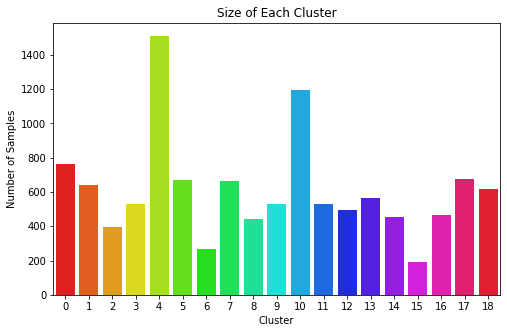

In [27]:
plt.figure(figsize=(8, 5))
plt.title("Size of Each Cluster")
ax = sns.barplot(y="Number of Samples", x="Cluster", data = cluster_counts_df, palette=colour_map)
plt.show()

Plot the time-series in each cluster and show the average shape

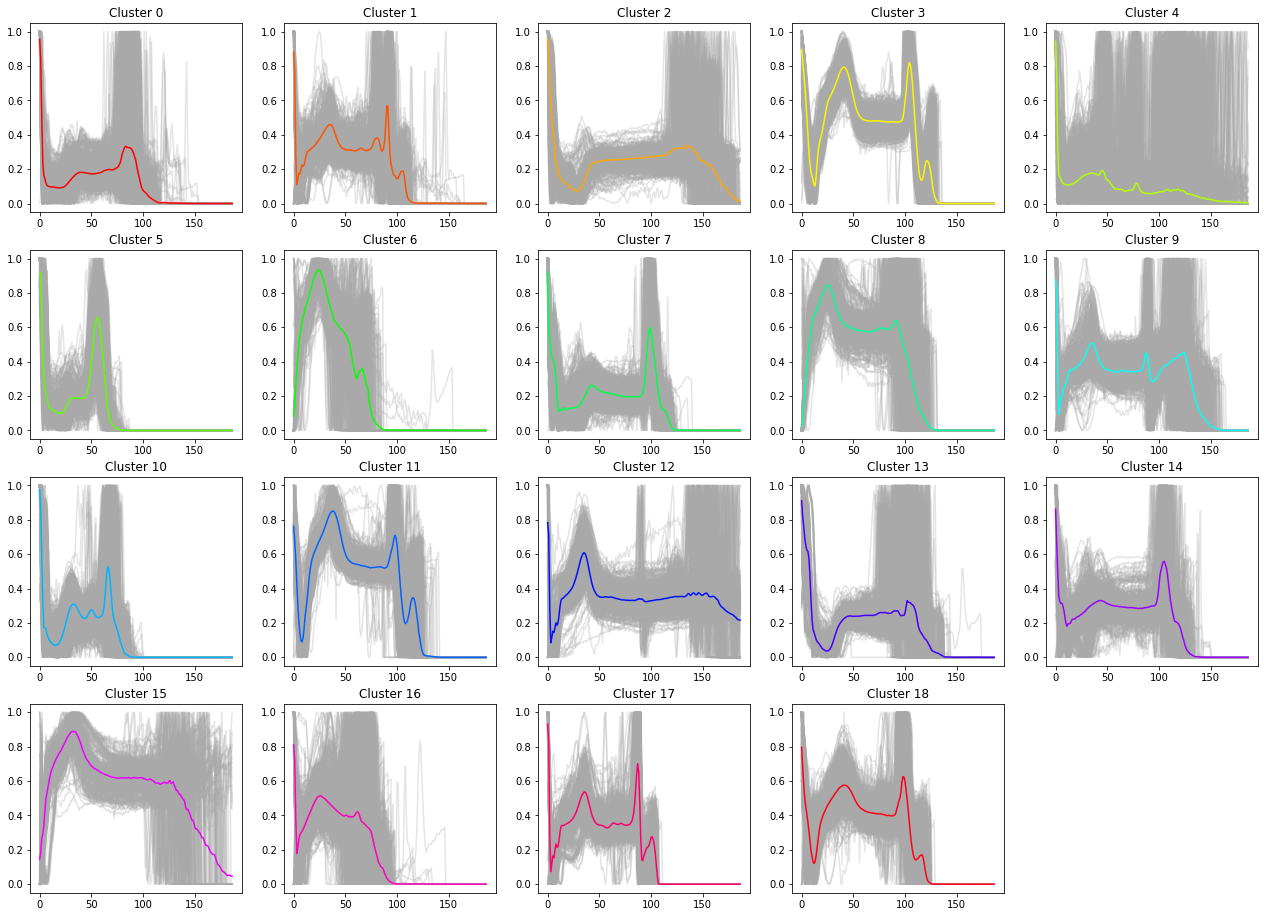

In [28]:
# Subplot dimensions
n_columns = 5
n_rows = math.ceil(len(np.unique(predicted_labels)) / n_columns)

# Create figure with subplots
fig, axes = plt.subplots(n_rows, n_columns, figsize=(22, n_rows*4))

for label, axis in zip(np.unique(predicted_labels), axes.flatten()):
  # Record the time-series samples of each cluster
  cluster = []
  for i in range(len(predicted_labels)):
    if predicted_labels[i] == label:
      axis.plot(X_train[i], c="darkgray", alpha=0.3)
      cluster.append(X_train[i])
  if len(cluster) > 0:
    # Plot average time-series of the cluster
    axis.plot(np.average(np.vstack(cluster), axis=0), c=colour_map[label])
  axis.set_title("Cluster " + str(label))
        
# Hide unused axes
for i, ax in enumerate(axes.flatten()):
    if i >= len(np.unique(predicted_labels)):
      ax.axis('off')

plt.show()

Plot a PCA graph on two principal components to view cluster distribution

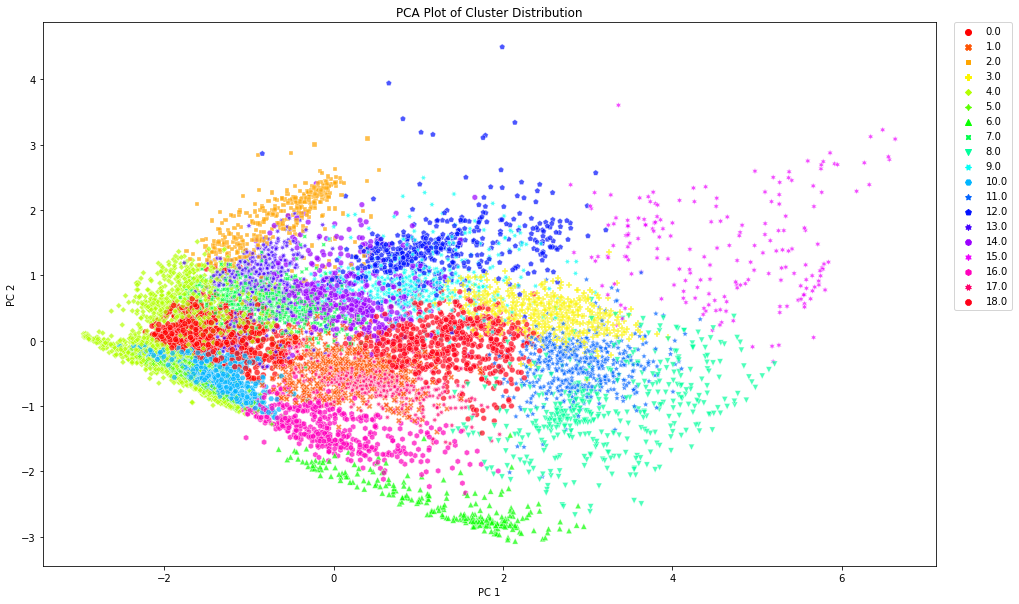

In [29]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_train)
pca_df = pd.DataFrame([predicted_labels, pca_result[:,0], pca_result[:,1]], index=['Cluster', 'PC 1', 'PC 2'], columns=selected_train_data.index.values).transpose()

plt.figure(figsize=(16,10))
plt.title("PCA Plot of Cluster Distribution")
sns.scatterplot(x="PC 1", y="PC 2", hue="Cluster", style="Cluster", alpha=0.7, palette=sns.color_palette(colour_map), data=pca_df)
# Move legend next to plot
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)
plt.show()

Plot a t-SNE graph to view cluster distribution

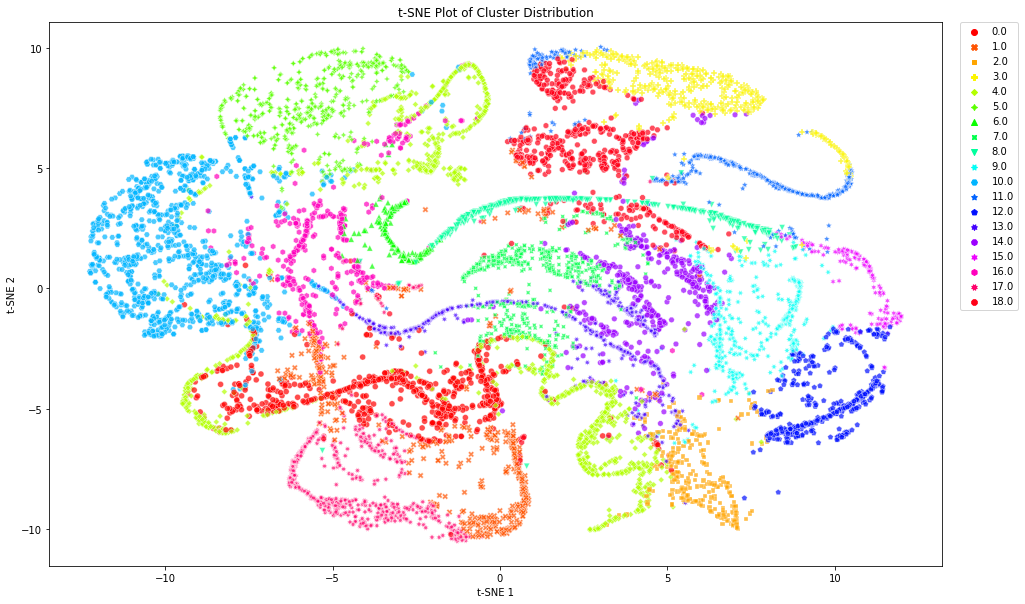

In [30]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_train)
tsne_df = pd.DataFrame([predicted_labels, tsne_results[:,0], tsne_results[:,1]], index=['Cluster', 't-SNE 1', 't-SNE 2'], columns=selected_train_data.index.values).transpose()

plt.figure(figsize=(16,10))
plt.title("t-SNE Plot of Cluster Distribution")
sns.scatterplot(x="t-SNE 1", y="t-SNE 2", hue="Cluster", style="Cluster", alpha=0.7, palette=sns.color_palette(colour_map), data=tsne_df)
# Move legend next to plot
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0)
plt.show()

# Save Clusters

### **Add Clusters to DataFrame**

Update train data by adding the cluster assignments as a column in the DataFrame

In [31]:
clustered_train_data = selected_train_data.copy()
# Shuffle order
clustered_train_data = clustered_train_data.sample(frac=1, random_state=1)
# Add cluster label as a column
clustered_train_data["Cluster"] = predicted_labels
clustered_train_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,Label,Augmentation,Cluster
107363,0.872659,0.815231,0.752809,0.685393,0.627965,0.539326,0.444444,0.357054,0.294632,0.287141,0.278402,0.220974,0.133583,0.146067,0.280899,0.334582,0.343321,0.358302,0.353308,0.343321,0.367041,0.394507,0.419476,0.449438,0.490637,0.504370,0.511860,0.523096,0.535581,0.548065,0.553059,0.561798,0.569288,0.593009,0.604245,0.626717,0.634207,0.655431,0.659176,0.660424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,NaN,5
108825,0.692771,0.582831,0.472892,0.335843,0.201807,0.091867,0.034639,0.000000,0.024096,0.075301,0.188253,0.295181,0.356928,0.412651,0.504518,0.558735,0.585843,0.590361,0.603916,0.602410,0.611446,0.599398,0.606928,0.605422,0.626506,0.628012,0.643072,0.647590,0.668675,0.670181,0.691265,0.707831,0.731928,0.736446,0.765060,0.777108,0.790663,0.793675,0.801205,0.792169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,NaN,14
102173,1.000000,0.954911,0.885668,0.766506,0.581320,0.384863,0.341385,0.423510,0.512077,0.566828,0.549114,0.473430,0.318841,0.247987,0.262480,0.262480,0.239936,0.210950,0.209340,0.206119,0.181965,0.157810,0.140097,0.128824,0.101449,0.099839,0.086957,0.099839,0.080515,0.088567,0.117552,0.122383,0.135266,0.133655,0.180354,0.194847,0.196457,0.217391,0.236715,0.252818,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,10
101154,1.000000,0.995588,0.895588,0.595588,0.526471,0.492647,0.457353,0.438235,0.422059,0.405882,0.398529,0.392647,0.382353,0.367647,0.357353,0.333824,0.311765,0.289706,0.258824,0.223529,0.188235,0.151471,0.123529,0.089706,0.061765,0.036765,0.022059,0.001471,0.000000,0.007353,0.020588,0.042647,0.075000,0.108824,0.155882,0.201471,0.255882,0.302941,0.347059,0.385294,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN,17
20244,1.000000,0.952607,0.727488,0.425355,0.177725,0.129147,0.140995,0.117299,0.093602,0.084123,0.071090,0.060427,0.047393,0.030806,0.021327,0.020142,0.008294,0.000000,0.002370,0.008294,0.027251,0.036730,0.048578,0.082938,0.110190,0.139810,0.176540,0.214455,0.244076,0.280806,0.309242,0.336493,0.347156,0.344787,0.350711,0.343602,0.330569,0.316351,0.293839,0.290284,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,NaN,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21682,0.992000,0.508000,0.536000,0.524000,0.540000,0.492000,0.496000,0.424000,0.328000,0.180000,0.032000,0.036000,0.100000,0.100000,0.112000,0.160000,0.160000,0.120000,0.112000,0.108000,0.124000,0.100000,0.096000,0.088000,0.092000,0.084000,0.088000,0.076000,0.076000,0.072000,0.096000,0.080000,0.108000,0.096000,0.120000,0.116000,0.160000,0.164000,0.200000,0.220000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,NaN,8
9065,1.000000,0.844156,0.487734,0.183261,0.000000,0.051948,0.125541,0.116883,0.105339,0.096681,0.092352,0.083694,0.080808,0.082251,0.079365,0.076479,0.092352,0.095238,0.092352,0.111111,0.131313,0.144300,0.1

### **Save Cluster Labels to File**

Save the new training data as a CSV. In Colab this can be seen and downloaded from "Files" on the right.

In [32]:
# Save as CSV file
clustered_train_data.to_csv('cluster_train_data.csv', index=True)